# An introduction to unfairness in ML

In this exercise, you will learn about some basic machine learning tasks and the fairness issues that could arise there.

## Installing the necessary libraries

In [1]:
pip install pandas folktables requests scikit-learn seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


# Exercise 1: Training risk prediction models

In this exercise, we will work with the ProPublic COMPAS dataset and train a risk prediction model.

#### A quick intro to the dataset
ProPublica, a news organization, compiled a list of all criminal oﬀenders screened through the COMPAS (Correctional Oﬀender Management Profiling for Alternative Sanctions) tool 5 in Broward County, Florida during 2013-2014. The data includes information on the defendents’ demographic features (gender, race, age), criminal history (charge for which the person was arrested, number of prior oﬀenses) and the risk score assigned to the oﬀender by COMPAS. ProPublica also collected the ground truth on whether or not these individuals actually recidivated within two years after the screening. To learn more about the dataset, see [this article](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).

#### Your task
Your task will be to inspect this data and train a risk prediction model on it.

## Exercise 1a: Download the data and select your features [20 mins]

The code below downloads the COMPAS dataset for you. You will be predicting whether a defendent will recidivate (commit a crime within next two year). The corresponding label is `two_year_recid`.

The COMPAS tool also trains a score ranging from 1 to 10 assigning the recidivism risk. We will train our own risk model and compare it against the COMPAS score.

Inspect the data and identify the features that you would like to use for training your risk prediction model. Create a new pandas dataframe that only contains the features that you are interested in. This will be your feature vector $\mathbf{x}$.

In [2]:
import folktables
from folktables import ACSDataSource, ACSEmployment
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd
from pathlib import Path
import requests


# Based on: https://fairlens.readthedocs.io/en/latest/user_guide/compas.html
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
local_name = Path("compas-scores-two-years.csv")
if not local_name.is_file():
    response = requests.get(url)
    with open("compas-scores-two-years.csv", "w") as f:
        f.write(response.content.decode("utf-8"))
df = pd.read_csv(local_name)
df = df.sample(frac=1, random_state=1)

df = df[(df["days_b_screening_arrest"] <= 30)
        & (df["days_b_screening_arrest"] >= -30)
        & (df["is_recid"] != -1)
        & (df["c_charge_degree"] != 'O')
        & (df["score_text"] != 'N/A')].reset_index(drop=True)

In [3]:
# Inspect the dataframe
pd.set_option('display.max_columns', None)
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,6055,juckendra toussaint,juckendra,toussaint,2014-05-08,Female,1992-12-06,23,Less than 25,African-American,0,3,0,0,0,0.0,2014-05-08 03:24:01,2014-05-09 02:12:07,14006419CF10A,2014-05-07,NaN,1.0,F,Aggravated Assault W/Dead Weap,1,14015627CF10A,(F3),0.0,2014-11-20,Crimin Mischief Damage $1000+,2014-11-20,2014-11-21,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,3,Low,2014-05-08,Risk of Violence,4,Low,2014-05-08,2014-11-20,2014-11-21,0,1,196,1,1
1,7760,aquaria mitchell,aquaria,mitchell,2013-01-14,Female,1993-01-14,23,Less than 25,African-American,0,10,0,0,2,-1.0,2013-01-13 12:08:49,2013-01-14 02:48:12,13000590CF10A,2013-01-13,NaN,1.0,F,Shoot Into Vehicle,1,14001123MM10A,(M2),0.0,2014-01-22,Petit Theft,2014-01-22,2014-01-22,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,10,High,2013-01-14,Risk of Violence,7,Medium,2013-01-14,2014-01-22,2014-01-22,2,0,373,0,1
2,7964,wanglee george,wanglee,george,2014-03-03,Male,1983-01-08,33,25 - 45,African-American,0,1,0,0,0,0.0,2014-03-03 03:25:46,2014-03-03 08:38:42,14003655MM10A,2014-03-03,NaN,0.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-03-03,Risk of Violence,1,Low,2014-03-03,2014-03-03,2014-03-03,0,0,760,0,0
3,3989,jorge castro,jorge,castro,2014-03-31,Male,1919-10-14,96,Greater than 45,Hispanic,0,2,0,0,2,-3.0,2014-03-28 12:45:33,2014-03-29 09:09:59,14004376CF10A,2014-03-28,NaN,3.0,F,Aggravated Assault W/Dead Weap,1,14014182MM10A,(M2),0.0,2014-09-25,Petit Theft,2014-09-25,2014-10-08,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,2,Low,2014-03-31,Risk of Violence,1,Low,2014-03-31,2014-09-25,2014-10-08,2,0,178,1,1
4,7254,elijah fortin,elijah,fortin,2013-11-13,Male,1995-09-15,20,Less than 25,Caucasian,0,4,0,0,0,-1.0,2013-11-12 12:33:38,2013-11-14 02:05:37,13015728CF10A,2013-11-12,NaN,1.0,F,Possession Burglary Tools,1,14016632CF10A,(F2),0.0,2014-12-15,"S/M/D/P/W/I Sch 1a,1b,1d,2a,2b",2014-12-15,2014-12-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-11-13,Risk of Violence,7,Medium,2013-11-13,2014-12-15,2014-12-16,0,1,397,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,1370,theresa brooks,theresa,brooks,2013-12-09,Female,1963-01-13,53,Greater than 45,Caucasian,0,1,0,0,0,-1.0,2013-12-08 05:37:02,2013-12-09 02:01:16,13022709MM10A,2013-12-08,NaN,1.0,M,DUI Property Damage/Injury,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-12-09,Risk of Violence,1,Low,2013-12-09,2013-12-08,2013-12-09,0,0,844,0,0
6168,7914,john davis,john,davis,2013-03-11,Male,1960-06-25,55,Greater than 45,Caucasian,0,1,0,0,0,-1.0,2013-03-10 12:30:14,2013-03-11 02:00:14,13004813MM10A,2013-03-09,NaN,2.0,M,DUI Level 0.15 Or Minor In Veh,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-11,Risk of Violence,1,Low,2013-03-11,2013-06-03,2013-06-19,0,0,84,0,0
6169,6074,steve rosewell,steve,rosewell,2013-05-15,Male,1967-11-02,48,Greater than 45,Other,0,2,0,0,7,-1.0,2013-05-14 06:11:09,2013-05-15 02:02:18,13006894CF10A,2013-05-14,NaN,1.0,F,Carrying Concealed Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,2,Low,2013-05-15,Risk of Violence,2,Low,2013-05-15,2013-05-14,2013

In [4]:
# Your code for separating out the features here
df.columns # List all the features

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [5]:
import matplotlib.pyplot as plt

selected_cols = [  # The features that we will use for classification
    "age",
    "juv_fel_count",
    "juv_misd_count",
    "juv_other_count",
    "priors_count",
    "c_charge_degree",
]
sens = "race"  #  Will not use for classification but use it for fairness analysis
label = "two_year_recid"  # The label we will try to predict

df_selected = df[selected_cols + [sens] + [label]]
df_selected

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,race,two_year_recid
0,23,0,0,0,0,F,African-American,1
1,23,0,0,0,2,F,African-American,1
2,33,0,0,0,0,M,African-American,0
3,96,0,0,0,2,F,Hispanic,1
4,20,0,0,0,0,F,Caucasian,1
...,...,...,...,...,...,...,...,...
6167,53,0,0,0,0,M,Caucasian,0
6168,55,0,0,0,0,M,Caucasian,0
6169,48,0,0,0,7,F,Other,0
6170,52,0,0,0,0,F,African-American,0


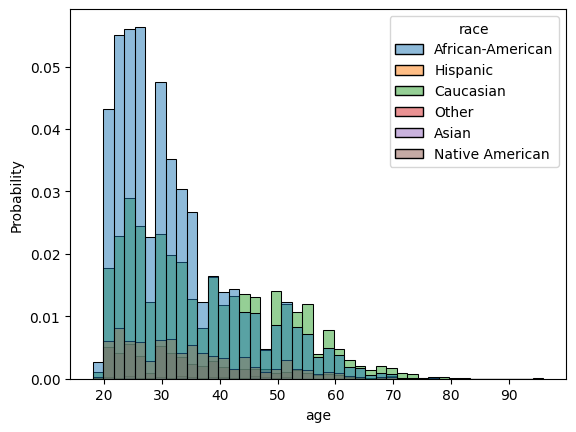

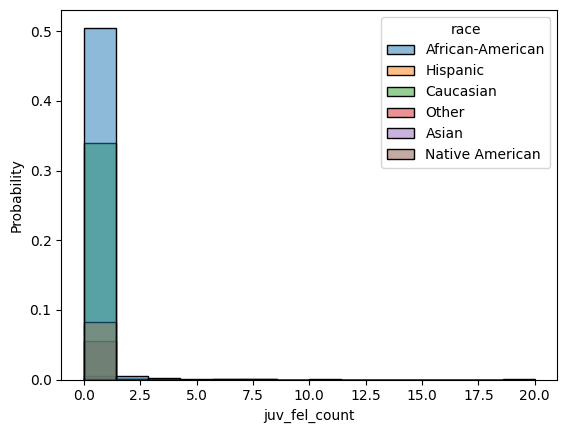

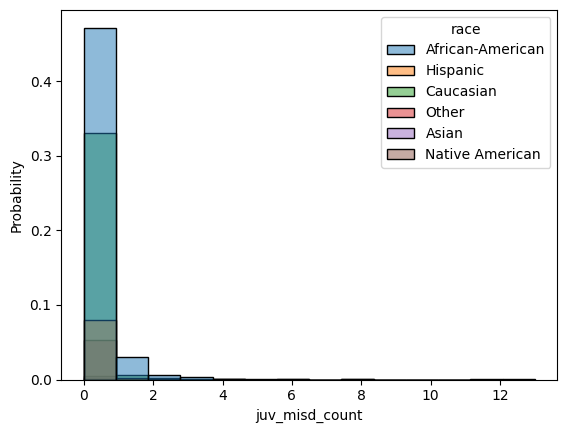

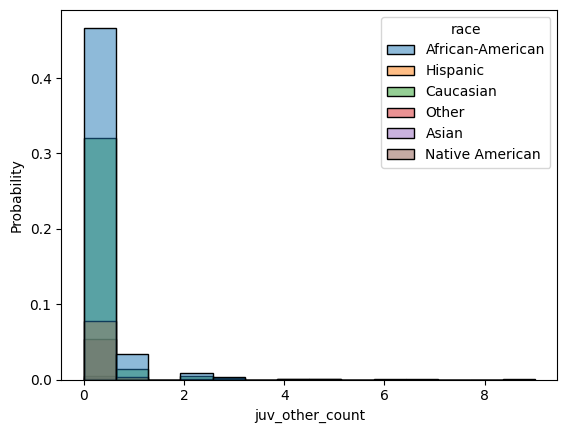

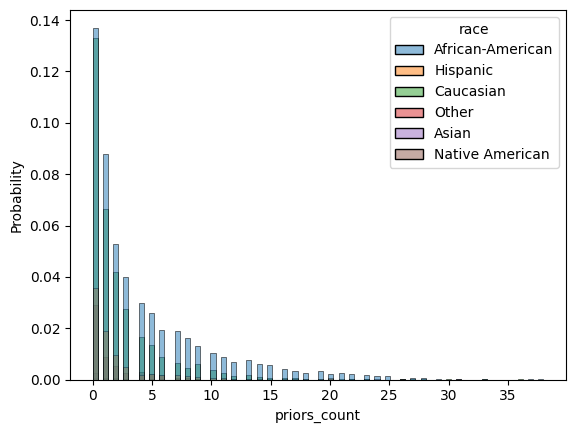

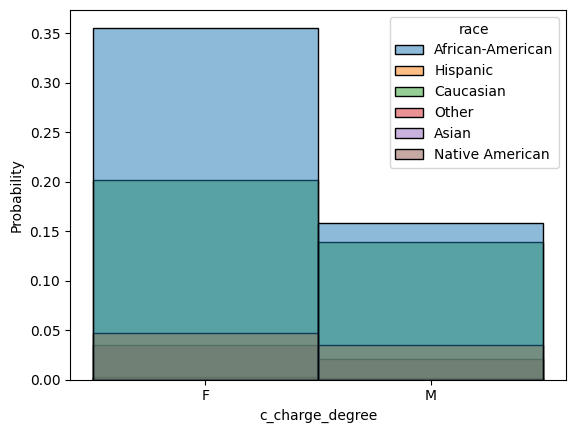

In [6]:
import seaborn as sns

for col in selected_cols:
    plt.figure()
    sns.histplot(df_selected, x=col, stat="probability", hue="race")

## Exercise 1b: Training and evaluating the risk predictors [25 mins]

Train a scikit learn [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model to predict the risk scores. Recall that the Logistic regression model assigns a probability of positive class as:
$$
p(y=1 | x) = 1 / [1 + \exp(-d(\mathbf{x}))]
$$

where $d(\mathbf{x})$ is the distance from the decision boundary.

You can access this probability using the [predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) method of the model.

Your tasks are:
1. Evaluate your risk prediction model based on accuracy, TPR, TNR, PPV, NPV and AUROC. Use a threshold of $0.5$ to binarize your decisions.
2. Evaluate the COMPAS risk prediction model (in the column `v_decile_score`) with the same metrics. Use a threshold of $5$ to binarize the decisions. How do the two scores compare?

In [7]:
y = df_selected[label].to_numpy()
z = df_selected[sens].to_numpy()
df_selected.drop(columns=[label, sens], inplace=True)
df_one_hot = pd.get_dummies(df_selected)
x = df_one_hot.to_numpy()
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, random_state=1122)

model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_risk = model.predict_proba(x_test)[:,1]

C:\Users\frede\AppData\Local\Temp\ipykernel_20756\1700171933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.drop(columns=[label, sens], inplace=True)


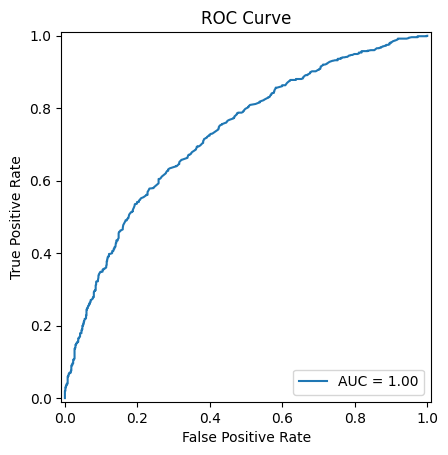

In [9]:
from sklearn.metrics import roc_curve, RocCurveDisplay

import matplotlib.pyplot as plt
y_true = y_test
y_score = y_risk
fpr, tpr, thresholds = roc_curve(y_true, y_score)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=1.0).plot()
plt.title("ROC Curve")
plt.show()


# Exercise 2: Measuring unfairness (25 mins)
Let us go back to the model we trained for the COMPAS data. Compute all the fairness metrics from the lecture slides. For computing fairness, consider the groups white and black. Can you think of ways to remove this unfairness?

In [ ]:
import sklearn

def compute_model_stats(y, y_pred, y_risk):
    tp = np.logical_and(y==1, y_pred==1).sum()
    tn = np.logical_and(y==0, y_pred==0).sum()
    fp = np.logical_and(y==0, y_pred==1).sum()
    fn = np.logical_and(y==1, y_pred==0).sum()
    return {
        "pos_frac": (y_pred==1).mean(),
        "acc": (y==y_pred).mean(),
        "tpr": tp / (tp + fn),
        "tnr": tn / (tn + fp),
        "ppv": tp / (tp + fp),
        "npv": tn / (tn + fn),
        "auc": sklearn.metrics.roc_auc_score(y, y_risk),
    }


perf_overall = compute_model_stats(y_test, y_pred, y_risk)
perf_white = compute_model_stats(y_test[z_test=="Caucasian"], y_pred[z_test=="Caucasian"], y_risk[z_test=="Caucasian"])
perf_black = compute_model_stats(y_test[z_test=="African-American"], y_pred[z_test=="African-American"], y_risk[z_test=="African-American"])

print(f"| {'metric':<10} |  All |  B   |   W  |")
for k in perf_overall.keys():
    print(f"| {k:<10} | {perf_overall[k]:0.2f} | {perf_black[k]:0.2f} | {perf_white[k]:0.2f} |")
    

## Exercise 3: Transferability of risk scores (20 mins)

You might recall the ACS employment data from the last lecture. We were trying to predict if someone is employed.

In this exercise, we will measure how transferable the risk scores are over different states. Below is the code to train download the data for the state of Alabama (AL). Train a model and compute its accuracy (you did that in the last exercise too).

How well does the model trained on AL generalize to different states like CA and TX?

---
Just to remind you, the features in the dataset are:

 * AGEP (Age)
 * SCHL (Educational attainment)
 * MAR (Marital status)
 * SEX (Sex): 1 denotes Male and 2 Female
 * DIS (Disability recode): 1 denotes a disability and 2 a disability
 * ESP (Employment status of parents)
 * MIG (Mobility status (lived here 1 year ago)
 * CIT (Citizenship status)
 * MIL (Military service)
 * ANC (Ancestry recode)
 * NATIVITY (Nativity)
 * RELP (Relationship)
 * DEAR (Hearing diﬃculty)
 * DEYE (Vision diﬃculty)
 * DREM (Cognitive diﬃculty)
 * RAC1P (Recoded detailed race code): (1 means white alone, 2 means Black or African American alone)
 * GCL (Grandparents living with grandchildren)


For more details of the precise feature values, see Appendix B4 of the paper (https://arxiv.org/pdf/2108.04884)

---

In [ ]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["AL"], download=True)  # Limiting to AL. You can try another state or all the states.
x, y, group = ACSEmployment.df_to_numpy(acs_data)  # The group in this case is the race. It is also included in the features.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(f"Test accuracy on AL: {(y_pred==y_test).mean(): 0.2f}")

In [ ]:
# Your code here

def print_performance(y_true, y_pred):
    print(f"Accuracy: {(y_true==y_pred).mean(): 0.2f}")
    print("Confusion matrix")
    with np.printoptions(precision=2):
        print(sklearn.metrics.confusion_matrix(y_true, y_pred, normalize="true"))

def test_old_model(old_model, target_state):
    x, y, group = ACSEmployment.df_to_numpy(data_source.get_data(states=[target_state], download=True))
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

    own_model = LogisticRegression(max_iter=1000)
    own_model.fit(x_train, y_train)

    y_pred_own = own_model.predict(x_test)
    y_pred_old = old_model.predict(x_test)

    print(f"\n== AL model performance on {target_state} data")
    print_performance(y_test, y_pred_old)
    print(f"\n== {target_state} model performance on {target_state} data")
    print_performance(y_test, y_pred_own)

test_old_model(model, "CA")
print("---------")
test_old_model(model, "TX")